In [53]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random
from sklearn.model_selection import train_test_split


# Creating a dataframe with our chosen features for different points and timesteps

In [2]:
#Import coral data (already transformed)

coral_data = pd.read_csv('/Users/maikentomren/Documents/prosjektoppgave/plotting git/Illuminating-the-deep---projections-/coral_data.csv')
coral_x = coral_data['x']
coral_y = coral_data['y']


In [3]:
#Import SINMOD data 
#here: gin, Trøndelag 
filename_PhysStates = 'PhysStates.nc' 
PhysStates_data = Dataset(filename_PhysStates, 'r')

t_range = 0, 10#len(PhysStates_data.dimensions['time'])



In [8]:
# Now make a function to create a dataframe for each feature of interest. Include points at both coral observations, and at random locations. Dimensions: 

def make_dataframe_for_a_feature(netcdf_data, coral_data, variable_name, t_range, generate_random=False):

    #Extracting data 
    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]
    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')
    t_start, t_stop = t_range


    # Extract variable values at coral data points
    coral_values = np.ndarray(shape=(len(coral_data['x']), len(range(t_start, t_stop))))

    valid_coordinates = []
    
    for i, point in enumerate(zip(coral_data['x']/hor_res, coral_data['y']/hor_res)):
        
        for j, time in enumerate(range(t_start, t_stop)):
            x, y = point
            # Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)
                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                    if value==0:
                        print('zero value current speed')
                        print('uvel: ',netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)])
                        print('vvel: ',netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)])
                        print('time: ', time)
                        print('layer_index: ', layer_index)
                        print('x: ', x)
                        print('y: ', y)

                elif variable_name == 'statistical_northness' or variable_name == 'statistical_eastness':
                    eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(58)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(58))
                    northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(58)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(58))
                    
                    if variable_name == 'statistical_eastness':
                        value = northward_velocity * np.sin(np.deg2rad(90)) + eastward_velocity * np.cos(np.deg2rad(90))
                        if value ==0:
                                print('zero value stat eastness')
                                print('uvel: ',netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)])
                                print('vvel: ',netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)])
                                print('time: ', time)
                                print('layer_index: ', layer_index)
                                print('x: ', x)
                                print('y: ', y)
                    else:
                        value = northward_velocity* np.cos(np.deg2rad(90)) - eastward_velocity * np.sin(np.deg2rad(90))
                        if value ==0:
                                print('zero value stat northness')
                                print('uvel: ',netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)])
                                print('vvel: ',netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)])
                                print('time: ', time)
                                print('layer_index: ', layer_index)
                                print('x: ', x)
                                print('y: ', y)
                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]
                    if value ==0:
                                print('zero value ', variable_name)
                                print('uvel: ',netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)])
                                print(variable_name, ': ',netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)])
                                print('time: ', time)
                                print('layer_index: ', layer_index)
                                print('x: ', x)
                                print('y: ', y)

                if not np.ma.is_masked(value):
                    coral_values[i, j] = value
                    valid_coordinates.append((int(x), int(y)))

    return coral_values

In [92]:
coral_values_test = make_dataframe_for_a_feature(PhysStates_data, coral_data, 'statistical_eastness', t_range, generate_random=False)


In [98]:
def sample_random_point(netcdf_data, coral_data, variables, t_range):
    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    t_start, t_stop = t_range

    # Extract variable values at coral data points
    random_samples = np.full((len(coral_data['x']), len(variables) + 1, len(range(t_range[0], t_range[1]))), 0, dtype=float)
    valid_coordinates = []

    no_points = len(coral_data['x'])

 
    valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

    selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)] 

    random_valid_coordinates = 0
    for i in range(len(variables)):
        for j, time in enumerate(range(t_start, t_stop)):
            #for k, point  in enumerate(selected_indices):
            correct_samples = 0
            while correct_samples < no_points:
                sample = random.choice(selected_indices)
                x, y = sample
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    if depth_at_point > 100:
                        random_depth = np.random.uniform(100, depth_at_point)
                    else:
                        random_depth = 100
                    #random_depth = np.random.uniform(100, depth_at_point) 
                    layer_index = np.searchsorted(cumulative_depth, random_depth)

                    if variables[i] == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                        if value == 0:
                            print('zero value current speed')
                            print('uvel: ',netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)])
                            print('vvel: ',netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)])
                            print('time: ', time)
                            print('layer_index: ', layer_index)
                            print('x: ', x)
                            print('y: ', y)
                    elif variables[i] == 'statistical_northness' or variables[i] == 'statistical_eastness':
                        eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(58)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(58))
                        northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(58)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(58))
                    
                        if variables[i] == 'statistical_eastness':
                            value = northward_velocity * np.sin(np.deg2rad(90)) + eastward_velocity * np.cos(np.deg2rad(90))

                            if value == 0:
                                print('zero value stat eastness')
                                print('uvel: ',netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)])
                                print('vvel: ',netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)])
                                print('time: ', time)
                                print('layer_index: ', layer_index)
                                print('x: ', x)
                                print('y: ', y)
                        else:
                            value = northward_velocity* np.cos(np.deg2rad(90)) - eastward_velocity * np.sin(np.deg2rad(90))
                            if value == 0:
                                print('zero value stat northness')
                                print('uvel: ',netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)])
                                print('vvel: ',netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)])
                                print('time: ', time)
                                print('layer_index: ', layer_index)
                                print('x: ', x)
                                print('y: ', y)
                    
                    else:
                        value = netcdf_data.variables[variables[i]][time, layer_index, int(y), int(x)]
                        if value == 0:
                            print('zero value ', variables[i])
                            print('uvel: ',netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)])
                            print(variables[i] ,netcdf_data.variables[variables[i]][time, layer_index, int(y), int(x)])
                            print('time: ', time)
                            print('layer_index: ', layer_index)
                            print('x: ', x)
                            print('y: ', y)

                    if not np.ma.is_masked(value):
                        if variables[i] == ('current_speed' or 'statistical_northness' or 'statistical_eastness'):
                            if not np.ma.is_masked(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]) and not np.ma.is_masked(netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]):
                                random_samples[correct_samples, i, j] = value
                                random_valid_coordinates += 1
                        else:
                            random_samples[correct_samples, i, j] = value
                            random_valid_coordinates += 1
                        #if (value != 0):
                        #    random_valid_coordinates += 1
                        #    random_samples[correct_samples, i, j] = value
                        #    correct_samples += 1

    print(f"Number of valid coordinates sampled: {random_valid_coordinates}")
    return random_samples


In [93]:
def make_dataframe_for_features(netcdf_data, coral_data, variables, t_range, generate_random):
    variables_array = np.full((len(coral_data['x']), len(variables) + 1, len(range(t_range[0], t_range[1]))), 1, dtype=float)


    for i in range(len(variables)):
        variable_values = make_dataframe_for_a_feature(netcdf_data, coral_data, variables[i], t_range, generate_random)
        variables_array[:, i, :] = variable_values

    return variables_array
    

#( num pointa, num features + 1, num timesteps)

In [94]:
variables = ['temperature', 'salinity', 'current_speed', 'statistical_northness', 'statistical_eastness']
coral_df = make_dataframe_for_features(PhysStates_data, coral_data, variables, t_range, generate_random=False)

/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_80039/1004754841.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)


In [99]:
random_df = sample_random_point(PhysStates_data, coral_data, variables, t_range)


#print(coral_df.shape)
#print(random_df)
#print(random_df[:,0,:])

KeyboardInterrupt: 

In [96]:
for i in range(len(variables)):
    values, counts = np.unique(random_df[:,i,:], return_counts=True)

    #print(counts)
    if np.min(abs(values)) == 0:
        zeroes = counts[0]
    else:
        zeroes = 0

    print(f"Variable {variables[i]} has {zeroes} zeroes")

Variable temperature has 0 zeroes
Variable salinity has 0 zeroes
Variable current_speed has 0 zeroes
Variable statistical_northness has 0 zeroes
Variable statistical_eastness has 0 zeroes


In [77]:
for i in range(len(variables)):
    values, counts = np.unique(coral_df[:,i,:], return_counts=True)

    #print(counts)
    if np.min(abs(values)) == 0:
        zeroes = counts[0]
    else:
        zeroes = 0

    print(f"Variable {variables[i]} has {zeroes} zeroes")

Variable temperature has 0 zeroes
Variable salinity has 0 zeroes
Variable current_speed has 720 zeroes
Variable statistical_northness has 0 zeroes
Variable statistical_eastness has 8 zeroes


In [42]:
for i in range(len(variables)):
    values, counts = np.unique(random_df[:,i,:], return_counts=True)


    print(f"lowest value for variable: {variables[i]}, {np.min(abs(values))}")

lowest value for variable: temperature, 0.00042724609375
lowest value for variable: salinity, 33.18048858642578
lowest value for variable: current_speed, 0.0006573888240382075
lowest value for variable: statistical_northness, 2.8991982502765984e-05
lowest value for variable: statistical_eastness, 6.492143307585614e-07


In [45]:
combined_array = np.concatenate((coral_df, random_df), axis=0)

print(combined_array.shape)

(208, 6, 10)


In [71]:
functions = [np.mean, np.min, np.max]

combined_df = pd.DataFrame()

variable_functions = {
    'temperature': [np.mean, np.min, np.max],
    'salinity': [np.mean, np.min, np.max],
    'current_speed': [np.mean, np.min, np.max],
    'statistical_northness': [np.mean, np.min, np.max],
    'statistical_eastness': [np.mean, np.min, np.max]
}

for i, key in enumerate(variable_functions.keys()):
    for function in variable_functions[key]:
        combined_df[key + '_' + function.__name__] = function(combined_array[:, i, :], axis=1)


combined_df['labels'] = function(combined_array[:, -1, :], axis=1)


In [72]:
# shuffle samples in dataframe

combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head()



,temperature_mean,temperature_min,temperature_max,salinity_mean,salinity_min,salinity_max,current_speed_mean,current_speed_min,current_speed_max,statistical_northness_mean,statistical_northness_min,statistical_northness_max,statistical_eastness_mean,statistical_eastness_min,statistical_eastness_max,labels
0,7.791241,7.678885,8.024842,34.718086,34.707939,34.752190,0.055965,0.011282,0.100848,-0.017563,-0.090083,0.052209,0.001246,-0.036327,0.045337,1.0
1,1.651838,-0.928801,4.961210,34.663229,33.774071,34.949799,0.060178,0.010845,0.259304,0.023271,-0.023966,0.167960,-0.009844,-0.086810,0.030765,0.0
2,7.821473,7.762993,7.882809,34.563507,34.555344,34.569839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
3,7.902963,7.870907,7.932005,34.731972,34.727776,34.742271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,1.778002,-0.950224,4.301035,34.737466,33.590199,34.961243,0.076072,0.013241,0.473782,-0.043133,-0.253842,0.035896,-0.021976,-0.058109,0.015516,0.0


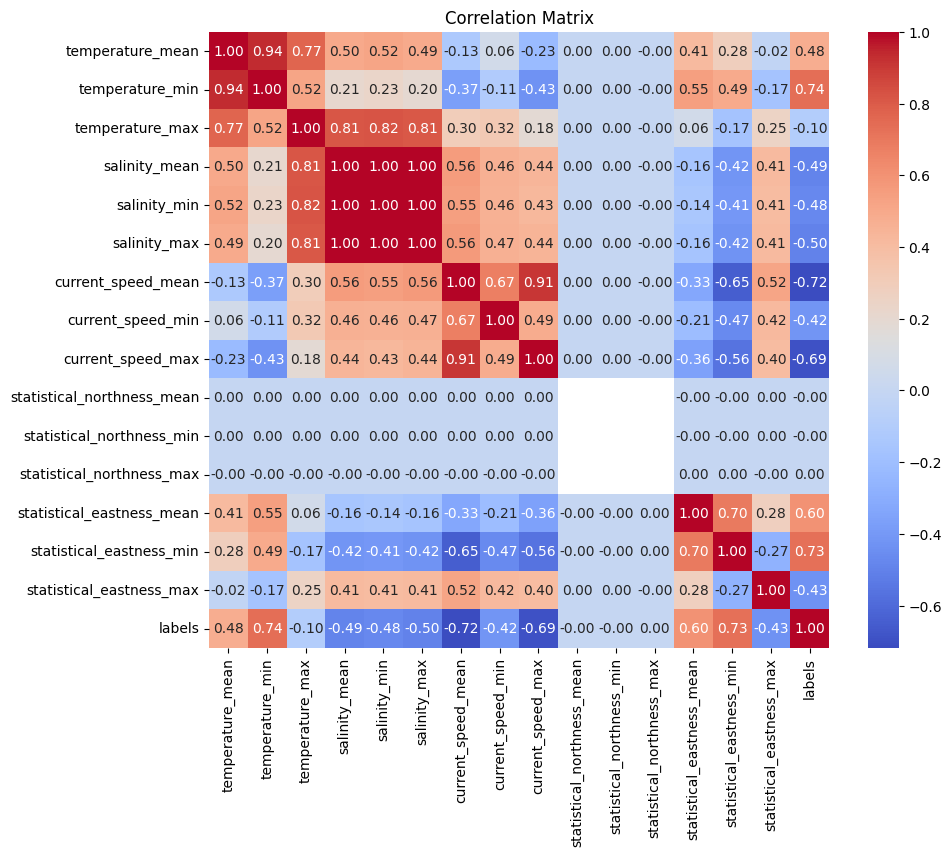

In [75]:
correlation_matrix = combined_df.corr()

correlation_matrix



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [73]:
scalar = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(combined_df[combined_df.columns[0:-1]], combined_df[combined_df.columns[-1]], test_size=0.2, random_state=42)

print(type(X_train))
X_train = pd.DataFrame(data=scalar.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scalar.transform(X_test), columns=X_test.columns)

<class 'pandas.core.frame.DataFrame'>


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1156: RuntimeWarning: overflow encountered in square
  temp **= 2
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:84: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


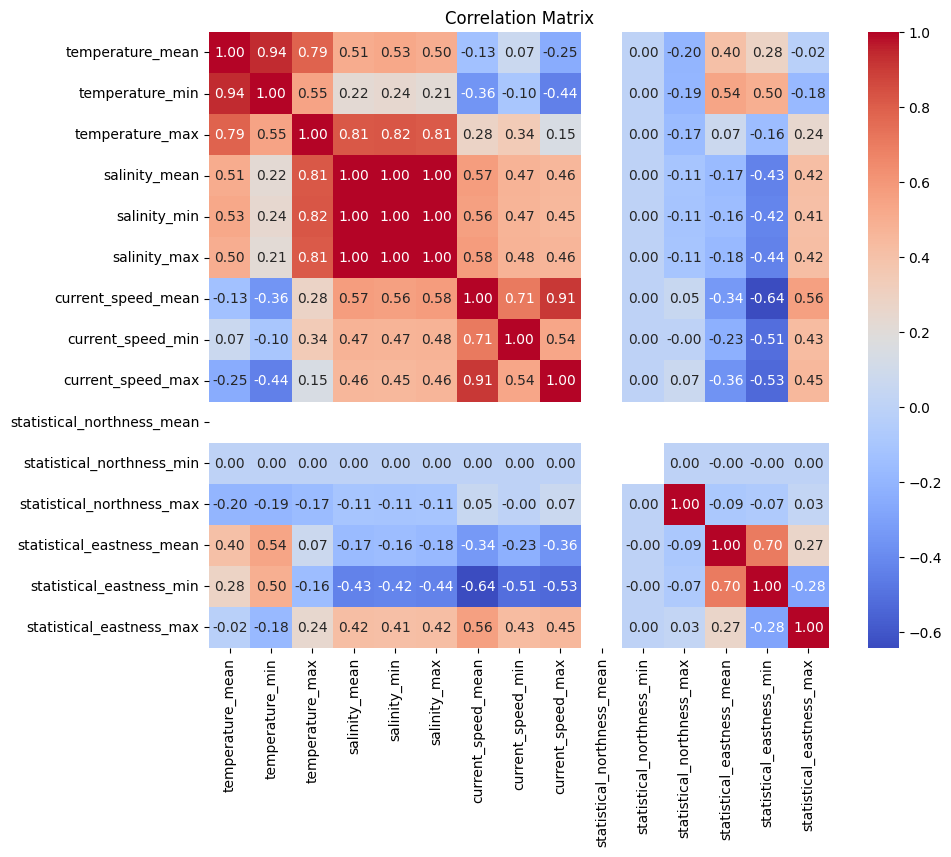

In [78]:
correlation_matrix = X_train.corr()

correlation_matrix



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [74]:
X_train.head()
y_train.head()

86     0.0
203    0.0
67     0.0
82     1.0
205    0.0
Name: labels, dtype: float64